In [23]:
import pickle
import os
import numpy as np
import cv2
from skimage import io
import random

In [24]:
BOXCARS_DATASET_ROOT = "C:\\Users\\George\\Desktop\\BoxCars-master\\DataBase\\BoxCars116k"

#%%

BOXCARS_IMAGES_ROOT = os.path.join(BOXCARS_DATASET_ROOT, "images")
BOXCARS_DATASET = os.path.join(BOXCARS_DATASET_ROOT, "dataset.pkl")
BOXCARS_ATLAS = os.path.join(BOXCARS_DATASET_ROOT, "atlas.pkl")
BOXCARS_CLASSIFICATION_SPLITS = os.path.join(BOXCARS_DATASET_ROOT, "classification_splits.pkl")
estimated_3DBB_path="C:\\Users\\George\\Desktop\\BoxCars-master\\data\\estimated_3DBB.pkl"

In [146]:
def load_cache(path, encoding="latin-1", fix_imports=True):
    with open(path, "rb") as f:
        return pickle.load(f, encoding=encoding, fix_imports=True)

#%%
def save_cache(path, data):
    with open(path, "wb") as f:
        pickle.dump(data, f)

In [147]:
class BoxCar():
    def __init__(self):
        self.X = {}
        self.Y = {}
        for part in ("train", "validation", "test"):
            self.X[part] = None
            self.Y[part] = None # for labels as array of 0-1 flags
        self.dataset=load_cache(BOXCARS_DATASET)
        self.atlas=load_cache(BOXCARS_ATLAS)
        self.split=load_cache(BOXCARS_CLASSIFICATION_SPLITS)['hard']
        self.estimated_3DBB = load_cache(estimated_3DBB_path)
        self.nr_of_classes=len(self.split["types_mapping"])
        
    def initialize_data(self, part):
        assert self.split is not None, "load classification split first"
        assert part in self.X, "unknown part -- use: train, validation, test"
        assert self.X[part] is None, "part %s was already initialized"%part
        data = self.split[part]
        x, y = [], []
        for vehicle_id, label in data:
            num_instances = len(self.dataset["samples"][vehicle_id]["instances"])
            x.extend([(vehicle_id, instance_id) for instance_id in range(num_instances)])
            y.extend([label]*num_instances)
        self.X[part] = np.asarray(x,dtype=int)

        y = np.asarray(y,dtype=int)
        y_categorical = np.zeros((y.shape[0], self.nr_of_classes))
        y_categorical[np.arange(y.shape[0]), y] = 1
        self.Y[part] = y_categorical
    
    def get_vehicle_instance_data(self, vehicle_id, instance_id):
        """
        original_image_coordinates: the 3DBB coordinates are in the original image space
                                    to convert them into cropped image space, it is necessary to subtract instance["3DBB_offset"]
                                    which is done if this parameter is False. 
        """
        vehicle = self.dataset["samples"][vehicle_id]
        instance = vehicle["instances"][instance_id]
        bb3d = self.estimated_3DBB[vehicle_id][instance_id]
        bb3d = bb3d - instance["3DBB_offset"]
        return vehicle, instance, bb3d 
    
    def get_image(self, vehicle_id, instance_id):
        """
        returns decoded image from atlas in RGB channel order
        """
        return cv2.cvtColor(cv2.imdecode(self.atlas[vehicle_id][instance_id], 1), cv2.COLOR_BGR2RGB)

In [148]:
data=BoxCar()
data.initialize_data("train")
data.initialize_data("validation")

In [205]:
#dataset.X['train']
np.shape(data.X['train'])

(51691, 2)

In [174]:
vehicle_id, instance_id=data.X["train"][695]

In [175]:
vehicle, instance, bb3d=data.get_vehicle_instance_data(vehicle_id, instance_id)

In [176]:
image = data.get_image(vehicle_id, instance_id)

In [177]:
print (data.atlas[vehicle_id][instance_id])

[[255]
 [216]
 [255]
 ...
 [ 25]
 [255]
 [217]]


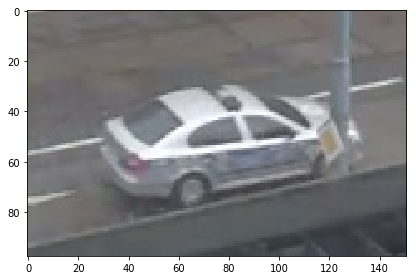

In [178]:
io.imshow(image)

In [179]:
def _unpack_side(img, origPoints, targetSize):
        
        origPoints = np.array(origPoints).reshape(-1,1,2)
        targetPoints = np.array([(0,0), (targetSize[0],0), (0, targetSize[1]), 
                             (targetSize[0], targetSize[1])]).reshape(-1,1,2).astype(origPoints.dtype)
        m, _ = cv2.findHomography(origPoints, targetPoints, 0)
        resultImage = cv2.warpPerspective(img, m, targetSize)
        return resultImage
def unpack_3DBB(img, bb): 
    io.imshow(img)
    frontal = _unpack_side(img, [bb[0], bb[1], bb[4], bb[5]], (75,124))
    side = _unpack_side(img, [bb[1], bb[2], bb[5], bb[6]], (149,124))
    roof = _unpack_side(img, [bb[0], bb[3], bb[1], bb[2]], (149,100))
    
    final = np.zeros((224,224,3), dtype=frontal.dtype)
    final[100:, 0:75] = frontal
    final[0:100, 75:] = roof
    final[100:, 75:] = side    
    return final

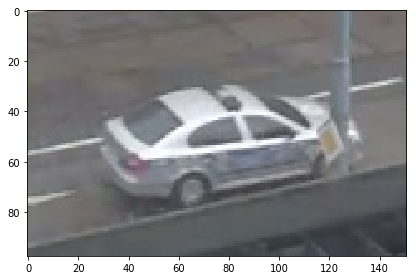

In [180]:
image = data.get_image(vehicle_id, instance_id)
io.imshow(image)


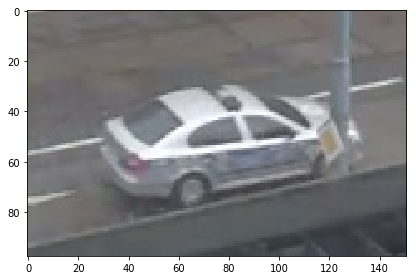

In [181]:
image = unpack_3DBB(image, bb3d) 

1.0859375

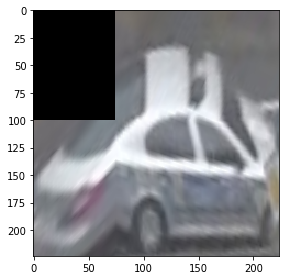

In [182]:
io.imshow(image)

image = (image.astype(np.float32) - 116)/128.
np.min(image)
np.max(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


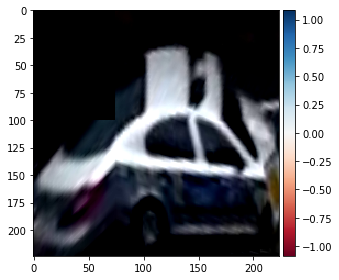

In [183]:
io.imshow(image)

In [184]:
y = data.Y['train'][6]

In [173]:
y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])